# IMDB project: predicting movies scores
### by Javier Alonso

This Jupyter Notebook is part of "My IMDB project" and tries to predict the rates of the movies in IMDB, based on the database published by IMDB

The database was downloaded from IMDB on 2020/05/25 but some days after they changed all the system for retrieving the data, so I won´t be able to upgrade easily the project with new data.

In this case we narrow the database to a specific decade and genre, comedies of the 2010´s decade, to see if the results are better

The results have been posted in my ["My blog"](https://javieralonsoalonso.com/category/my-imdb-project/)

## Table of Contents

1. [Preliminary Wrangling](#Preliminary_Wrangling)<br>
1.a.-[Gathering Data](#Gathering_Data)<br>
1.b.-[Assesing and Cleaning Data](#Assesing_cleaning_data)<br>
1.c.-[Consolidation of Dataframes](#Consolidaion_dataframes)<br>
2. [Machine Learning Algorithm](#MLA)<br>
3.a.-[Data preparation](#Data_preparation)<br>
3.b.-[Algorithm Selection](#Alg_Selection)<br>


## <a class="anchor" id="Preliminary_Wrangling">Part 1: Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import time

%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform as sp_rand
from scipy.stats import uniform as sp_randFloat
from scipy.stats import uniform as sp_randInt
from scipy.stats import uniform as sp_random

### <a class="anchor" id="Gathering_Data"> 1.a.- Gathering Data

In this section we´ll gather data from the precleaned dataset for the EDA

In [2]:
df_movies = pd.read_csv('IMDB_clean_movies.csv')
df_movies.shape

(221748, 12)

A view of the dataframe

In [3]:
df_movies.head(5)

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,director,actors,actress,writers
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,Alexander Black,"William Courtenay,Chauncey Depew",Blanche Bayliss,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,Enoch J. Rector,Not available,Not available,Not available
2,tt0000335,Soldiers of the Cross,1900,91,"Biography,Drama",6.1,40,1900,"Herbert Booth,Joseph Perry","Harold Graham,Mr. Graham,John Jones,Orrie Perr...",Beatrice Day,Not available
3,tt0000502,Bohemios,1905,100,No available,3.8,6,1900,Ricardo de Baños,"Antonio del Pozo,El Mochuelo",Not available,"Marguerite Thévenard,Bleuette Bernon"
4,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,Charles Tait,"John Tait,Norman Campbell","Elizabeth Tait,Bella Cola",Not available


### <a class="anchor" id="Assesing_cleaning_data"> 1.b.- Asessing and cleaning data

Now, we´re going to assess the dataframe visually and programmatically for quality and tidiness issues, and do the cleaning of these issues

First thing we do a copy of my dataframe


In [4]:
movies = df_movies.copy()

In [5]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,director,actors,actress,writers
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,Alexander Black,"William Courtenay,Chauncey Depew",Blanche Bayliss,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,Enoch J. Rector,Not available,Not available,Not available
2,tt0000335,Soldiers of the Cross,1900,91,"Biography,Drama",6.1,40,1900,"Herbert Booth,Joseph Perry","Harold Graham,Mr. Graham,John Jones,Orrie Perr...",Beatrice Day,Not available
3,tt0000502,Bohemios,1905,100,No available,3.8,6,1900,Ricardo de Baños,"Antonio del Pozo,El Mochuelo",Not available,"Marguerite Thévenard,Bleuette Bernon"
4,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,Charles Tait,"John Tait,Norman Campbell","Elizabeth Tait,Bella Cola",Not available


#### Keeping movies with more than 1000 votes

For the prediction we will keep only movies with more than 1000 votes

In [7]:
len(movies)

221748

In [8]:
movies = movies[movies.numVotes>1000]

In [9]:
len(movies)

30381

So we will try to predict the rates in 11.086 movies that are the top 5% most voted movies.

#### Incorrect datatypes

Decade should be string. We change the datatype

In [10]:
movies.decade = movies.decade.astype(str)

In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30381 entries, 63 to 221712
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        30381 non-null  object 
 1   originalTitle  30381 non-null  object 
 2   Year           30381 non-null  int64  
 3   Minutes        30381 non-null  int64  
 4   Genres         30381 non-null  object 
 5   averageRating  30381 non-null  float64
 6   numVotes       30381 non-null  int64  
 7   decade         30381 non-null  object 
 8   director       30381 non-null  object 
 9   actors         30381 non-null  object 
 10  actress        30379 non-null  object 
 11  writers        30381 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 3.0+ MB


#### Deleting columns

**Director, actors, actress and writers column** as we will get them from other dataframe

In [12]:
movies = movies.drop(['director'], axis=1)
movies = movies.drop(['actors'], axis=1)
movies = movies.drop(['actress'], axis=1)
movies = movies.drop(['writers'], axis=1)

In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30381 entries, 63 to 221712
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        30381 non-null  object 
 1   originalTitle  30381 non-null  object 
 2   Year           30381 non-null  int64  
 3   Minutes        30381 non-null  int64  
 4   Genres         30381 non-null  object 
 5   averageRating  30381 non-null  float64
 6   numVotes       30381 non-null  int64  
 7   decade         30381 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 2.1+ MB


#### Transforming Skewed Continuous Features

In [14]:
movies.skew(axis = 0) 

Year            -1.277185
Minutes          2.977239
averageRating   -0.886599
numVotes         8.877122
decade          -1.292822
dtype: float64

The rating is aprox Symetric and decade is in reality a cathegory, so we don´t mind Skew of both of them.

We are going to transform Minutes and numVotes for reducing Skewness, due to their high level

In [15]:
movies.Minutes = movies.Minutes.apply(lambda x: np.log(x + 1))
movies.numVotes = movies.numVotes.apply(lambda x: np.log(x + 1))

The skewness has been reduced

In [16]:
movies.skew(axis = 0) 

Year            -1.277185
Minutes          0.724885
averageRating   -0.886599
numVotes         1.100125
decade          -1.292822
dtype: float64

#### Normalizing Numerical Features

In [17]:
movies.describe()

,Year,Minutes,averageRating,numVotes
count,30381.000000,30381.000000,30381.000000,30381.000000
mean,1996.273296,4.646675,6.369715,8.618922
std,21.809789,0.190854,1.131128,1.485920
min,1911.000000,3.828641,1.000000,6.909753
25%,1986.000000,4.521789,5.700000,7.442493
50%,2004.000000,4.615121,6.500000,8.173011
75%,2013.000000,4.744932,7.200000,9.417192
max,2020.000000,6.593045,9.500000,14.622942


In [18]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Minutes', 'averageRating', 'numVotes','Year']

movies[numerical] = scaler.fit_transform(movies[numerical])

In [19]:
movies.describe()

,Year,Minutes,averageRating,numVotes
count,30381.000000,30381.000000,30381.000000,30381.000000
mean,0.782324,0.295917,0.631731,0.221590
std,0.200090,0.069040,0.133074,0.192647
min,0.000000,0.000000,0.000000,0.000000
25%,0.688073,0.250740,0.552941,0.069069
50%,0.853211,0.284502,0.647059,0.163779
75%,0.935780,0.331461,0.729412,0.325085
max,1.000000,1.000000,1.000000,1.000000


In [20]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade
63,tt0002130,L'Inferno,0.000000,0.146674,"Adventure,Drama,Fantasy",0.705882,0.100063,1910
92,tt0002844,Fantômas - À l'ombre de la guillotine,0.018349,0.064640,"Crime,Drama",0.705882,0.084043,1910
102,tt0003037,Juve contre Fantômas,0.018349,0.107977,"Crime,Drama",0.705882,0.037200,1910
107,tt0003165,Le mort qui tue,0.018349,0.246787,"Crime,Drama,Mystery",0.705882,0.004076,1910
118,tt0003419,Der Student von Prag,0.018349,0.226344,"Drama,Fantasy,Horror",0.647059,0.071253,1910


**Getting the genre dummies**

In [21]:
movies = movies.join(movies.Genres.str.get_dummies(sep=',').add_prefix('genre_'))
movies = movies.drop(['Genres'], axis=1)

In [23]:
movies.columns

Index(['idMovie', 'originalTitle', 'Year', 'Minutes', 'averageRating',
       'numVotes', 'decade', 'genre_Action', 'genre_Adult', 'genre_Adventure',
       'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_Film-Noir', 'genre_History', 'genre_Horror', 'genre_Music',
       'genre_Musical', 'genre_Mystery', 'genre_News', 'genre_No available',
       'genre_Romance', 'genre_Sci-Fi', 'genre_Sport', 'genre_Thriller',
       'genre_War', 'genre_Western'],
      dtype='object')

**Filtering the Comedies from 2010's decade**

In [27]:
len(movies)

30381

In [35]:
movies = movies[(movies.genre_Comedy==1) & (movies.decade == '2010')]

In [36]:
len(movies)

3423

#### Getting the crews info

I read the file created in the first part of the predictions ( IMDB_predictions_test_0.ipynb )

In [38]:
crew = pd.read_csv('IMDB_clean_crew.csv')

**Merging the information**

In [39]:
movies = pd.merge(movies, crew, left_on = 'idMovie', right_on = 'tconst', how = 'left')

In [40]:
movies.columns

Index(['idMovie', 'originalTitle', 'Year', 'Minutes', 'averageRating',
       'numVotes', 'decade', 'genre_Action', 'genre_Adult', 'genre_Adventure',
       'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_Film-Noir', 'genre_History', 'genre_Horror', 'genre_Music',
       'genre_Musical', 'genre_Mystery', 'genre_News', 'genre_No available',
       'genre_Romance', 'genre_Sci-Fi', 'genre_Sport', 'genre_Thriller',
       'genre_War', 'genre_Western', 'tconst', 'actor', 'actress', 'director',
       'writer'],
      dtype='object')

In [42]:
len(movies)

3423

In [43]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3423 entries, 0 to 3422
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idMovie             3423 non-null   object 
 1   originalTitle       3423 non-null   object 
 2   Year                3423 non-null   float64
 3   Minutes             3423 non-null   float64
 4   averageRating       3423 non-null   float64
 5   numVotes            3423 non-null   float64
 6   decade              3423 non-null   object 
 7   genre_Action        3423 non-null   int64  
 8   genre_Adult         3423 non-null   int64  
 9   genre_Adventure     3423 non-null   int64  
 10  genre_Animation     3423 non-null   int64  
 11  genre_Biography     3423 non-null   int64  
 12  genre_Comedy        3423 non-null   int64  
 13  genre_Crime         3423 non-null   int64  
 14  genre_Documentary   3423 non-null   int64  
 15  genre_Drama         3423 non-null   int64  
 16  genre_

In [44]:
#We delete the nans
movies = movies.dropna()

In [45]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3414 entries, 0 to 3422
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idMovie             3414 non-null   object 
 1   originalTitle       3414 non-null   object 
 2   Year                3414 non-null   float64
 3   Minutes             3414 non-null   float64
 4   averageRating       3414 non-null   float64
 5   numVotes            3414 non-null   float64
 6   decade              3414 non-null   object 
 7   genre_Action        3414 non-null   int64  
 8   genre_Adult         3414 non-null   int64  
 9   genre_Adventure     3414 non-null   int64  
 10  genre_Animation     3414 non-null   int64  
 11  genre_Biography     3414 non-null   int64  
 12  genre_Comedy        3414 non-null   int64  
 13  genre_Crime         3414 non-null   int64  
 14  genre_Documentary   3414 non-null   int64  
 15  genre_Drama         3414 non-null   int64  
 16  genre_

**Keeping only the important crew**

In [46]:
movies.head()

,idMovie,originalTitle,Year,Minutes,averageRating,numVotes,decade,genre_Action,genre_Adult,genre_Adventure,...,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western,tconst,actor,actress,director,writer
0,tt0359950,The Secret Life of Walter Mitty,0.935780,0.331461,0.741176,0.732867,2010,0,0,0,...,0,0,0,0,0,tt0359950,Ben Stiller,Kristen Wiig,Not available,Steve Conrad
1,tt0365545,Nappily Ever After,0.981651,0.277267,0.635294,0.256842,2010,0,0,0,...,0,0,0,0,0,tt0365545,Ricky Whittle,Sanaa Lathan,Haifaa Al-Mansour,Adam Brooks
2,tt0376136,The Rum Diary,0.917431,0.346856,0.611765,0.593125,2010,0,0,0,...,0,0,0,0,0,tt0376136,Johnny Depp,Not available,Bruce Robinson,Hunter S. Thompson
3,tt0377981,Gnomeo & Juliet,0.917431,0.222113,0.576471,0.509901,2010,0,0,1,...,0,0,0,0,0,tt0377981,James McAvoy,Emily Blunt,Kelly Asbury,Rob Sprackling
4,tt0383010,The Three Stooges,0.926606,0.254651,0.470588,0.437904,2010,0,0,0,...,0,0,0,0,0,tt0383010,Sean Hayes,Jane Lynch,Bobby Farrelly,Mike Cerrone


In [47]:
n_actors = len(movies.actor.unique())
n_actress = len(movies.actress.unique())
n_director = len(movies.director.unique())
n_writer = len(movies.writer.unique())

In [48]:
print("There are", n_actors, "different actors,", n_actress,"different actresses,", n_director," different directors and", n_writer,"different writers")

There are 2115 different actors, 1978 different actresses, 2333  different directors and 1996 different writers


With these numbers a lot of different dummies columns will be created, so we are going to delimit them to 1000 for each category, that will be the ones that are present in more movies

In [49]:
n = 1000
top_actors = movies[movies.actor != 'Not available'].groupby("actor")['idMovie'].count()
top_actors = top_actors.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['actor'].head(n).to_list()
top_actress = movies[movies.actress != 'Not available'].groupby("actress")['idMovie'].count()
top_actress = top_actress.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['actress'].head(n).to_list()
top_director = movies[movies.director != 'Not available'].groupby("director")['idMovie'].count()
top_director = top_director.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['director'].head(n).to_list()
top_writer = movies[movies.writer != 'Not available'].groupby("writer")['idMovie'].count()
top_writer = top_writer.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['writer'].head(n).to_list()

In [50]:
movies.actor.value_counts()

Not available      109
Akshay Kumar        18
Adam Sandler        17
Jason Bateman       12
Steve Carell        12
                  ... 
Alex Lvovsky         1
Arthur Pelling       1
Kenneth Hadley       1
Jacob Matschenz      1
Hugo Weaving         1
Name: actor, Length: 2115, dtype: int64

In [51]:
movies.actor = movies.actor.apply(lambda x: x if x in top_actors else "Not available")
movies.actress = movies.actress.apply(lambda x: x if x in top_actress else "Not available")
movies.director = movies.director.apply(lambda x: x if x in top_director else "Not available")
movies.writer = movies.writer.apply(lambda x: x if x in top_writer else "Not available")

In [52]:
movies.actor.value_counts()

Not available      1223
Akshay Kumar         18
Adam Sandler         17
Jason Bateman        12
Steve Carell         12
                   ... 
Niels Schneider       1
Vicky Kaushal         1
Tishuan Scott         1
Steve Austin          1
Oscar Dietz           1
Name: actor, Length: 1001, dtype: int64

### Creating Dummy columns

In [53]:
# movies = movies.drop(['genre_No available'], axis=1)
movies = movies.drop(['tconst'], axis=1)

In [54]:
movies_final = pd.get_dummies(movies, prefix=['dec_','actor_','actress_','dir_','writ_'], columns=['decade','actor','actress','director','writer'])

In [55]:
movies_final = movies_final.drop(['actor__Not available','dir__Not available','actress__Not available','writ__Not available'], axis=1)

In [56]:
movies_final.head()

,idMovie,originalTitle,Year,Minutes,averageRating,numVotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,...,writ__Zack Kahn,writ__Zack Stentz,writ__Zafer Külünk,writ__Zeb Wells,writ__Zeenat Lakhani,writ__Zeynep Kocak,writ__Zhenyun Liu,writ__Zhilong Lei,writ__Zsófia Ruttkay,writ__Ólafur Egilsson
0,tt0359950,The Secret Life of Walter Mitty,0.935780,0.331461,0.741176,0.732867,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0365545,Nappily Ever After,0.981651,0.277267,0.635294,0.256842,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0376136,The Rum Diary,0.917431,0.346856,0.611765,0.593125,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0377981,Gnomeo & Juliet,0.917431,0.222113,0.576471,0.509901,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,tt0383010,The Three Stooges,0.926606,0.254651,0.470588,0.437904,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
movies_final.shape

(3414, 4032)

### <a class="anchor" id="Consolidaion_dataframes"> 1.c.- Consolidation of dataframes

In this section we´re going to consolidate both dataframes into files, that we´ll read for the next sections

In [58]:
movies_final.to_csv('IMDB_clean_movies_test_2.csv', index = False)

## <a class="anchor" id="MLA">Part 2: Machine learning algorithm

### <a class="anchor" id="Data_preparation"> 3.a.- Data preparation
We import the data and fix importation issues

In [59]:
movies = pd.read_csv('IMDB_clean_movies_test_2.csv')

In [60]:
movies.shape

(3414, 4032)

In [61]:
movies.head()

,idMovie,originalTitle,Year,Minutes,averageRating,numVotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,...,writ__Zack Kahn,writ__Zack Stentz,writ__Zafer Külünk,writ__Zeb Wells,writ__Zeenat Lakhani,writ__Zeynep Kocak,writ__Zhenyun Liu,writ__Zhilong Lei,writ__Zsófia Ruttkay,writ__Ólafur Egilsson
0,tt0359950,The Secret Life of Walter Mitty,0.935780,0.331461,0.741176,0.732867,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0365545,Nappily Ever After,0.981651,0.277267,0.635294,0.256842,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0376136,The Rum Diary,0.917431,0.346856,0.611765,0.593125,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0377981,Gnomeo & Juliet,0.917431,0.222113,0.576471,0.509901,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,tt0383010,The Three Stooges,0.926606,0.254651,0.470588,0.437904,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
movies1 = movies.copy()
movies1 = movies1[['averageRating']]

In [63]:
movies1.shape

(3414, 1)

In [64]:
movies2 = movies.copy()
movies2 = movies2.drop(['idMovie','originalTitle','averageRating'], axis=1)

In [65]:
movies2.shape

(3414, 4029)

#### Applying PCA

In this section we will apply feature reduction with PCA to the dataset with default values, without fixing the number of components. We will do it over movies2, that hasn´t categorical variables

In [66]:
# Apply PCA to the data.
pca = PCA()
movies_pca = pca.fit_transform(movies2)

In [67]:
column_names = ["Component", "variance", "acumulative_variance"]
variances = pd.DataFrame(columns = column_names)
var_acu = 0
for i in range(len(pca.explained_variance_ratio_)):
    comp = i +1 
    var = pca.explained_variance_ratio_[i]
    var_acu = var_acu +  var
    variances.loc[i] = [comp, var, var_acu]

Now we plot the acumulative and individual variance ratio versus the number oc principal components used

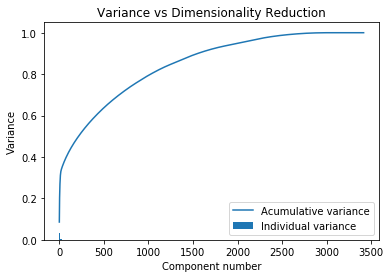

In [68]:
plt.plot(variances.Component, variances.acumulative_variance);
plt.bar(variances.Component, variances.variance);
plt.xlabel('Component number') 
plt.ylabel('Variance');
plt.legend(['Acumulative variance','Individual variance']);
plt.title('Variance vs Dimensionality Reduction');

In [69]:
variances.head()

,Component,variance,acumulative_variance
0,1.0,0.085792,0.085792
1,2.0,0.052588,0.138381
2,3.0,0.033749,0.172130
3,4.0,0.032075,0.204204
4,5.0,0.022566,0.226770


We´ve decided to keep the 95% of the variability in the original data, so we are going to reduce the dataframe to 2010 dimensions (the initial variables where 4038)

In [70]:
for i in range(len(variances)):
    if variances.acumulative_variance[i] > 0.95:
        num = i
        var = variances.acumulative_variance[i]
        break
        
print("Using", i, "variables, we can explain", round(var,2), "of the variability in the original data.")

Using 2010 variables, we can explain 0.95 of the variability in the original data.


In [71]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 2010)
movies_pca = pca.fit_transform(movies2)

In [72]:
movies_pca_end = pd.DataFrame(movies_pca)
movies_pca_end.head()

,0,1,2,3,4,5,6,7,8,9,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,-0.501549,-0.410343,0.063990,-0.009437,-0.088713,-0.045979,0.750477,0.803670,0.057858,0.031380,...,0.000421,0.003627,0.009862,0.005714,0.006536,0.022481,0.002074,0.004446,0.020332,0.007569
1,-0.829292,0.497783,0.010107,0.258482,-0.002734,0.080488,0.023413,-0.030326,-0.014422,0.022024,...,-0.031919,-0.011752,0.002483,0.023398,0.018066,-0.023044,-0.012915,-0.000700,0.025116,0.026440
2,-0.515000,-0.395089,0.050315,0.033801,-0.009854,0.035081,0.093133,0.106137,0.319056,-0.034632,...,-0.017177,-0.003525,0.008375,0.001137,0.010435,0.025869,0.009259,0.026473,0.008463,0.012705
3,0.679223,-0.151883,1.110699,0.354617,0.286754,0.248088,0.010799,0.060866,0.100866,0.352594,...,0.001213,-0.009749,0.031196,-0.021931,-0.001122,-0.024269,-0.015693,0.009335,-0.013628,-0.000166
4,0.361933,-0.009221,0.143055,-0.340032,0.042796,-0.492464,0.595843,-0.546854,0.240167,-0.102851,...,0.010785,-0.007490,0.020632,-0.009844,-0.024513,-0.018635,0.005081,0.021210,-0.010861,0.001051


#### Interpreting Principal Components

Now that we have our transformed principal components, we are going to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In [73]:
def pc_indexes(df, pca, n):
    """
    Gives the 10 most important variables with its weights in the component n after applying pca to de dataframe df
    
    INPUT: df (dataframe), pca (transformation applied), n(principal component to analyze)
    OUTPUT: list of the top 10 variables and their weights
    """

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = dimensions
    df_comp = components.iloc[n-1].to_frame()
    df_comp["Abs_value"] = df_comp.abs()
    df_comp = df_comp.sort_values(by='Abs_value', ascending = False)
    df_comp = df_comp[df_comp.columns[0]].head(10)
    return df_comp


In [74]:
# Get weights for the first principal component
pc_indexes(movies2, pca, 1)

genre_Drama       -0.8592
genre_Romance     -0.3048
genre_Action       0.2929
genre_Adventure    0.2180
genre_Animation    0.1131
genre_Horror       0.0961
genre_Crime        0.0872
genre_Thriller     0.0260
genre_Family       0.0198
genre_Music       -0.0172
Name: Dimension 1, dtype: float64

In [75]:
pc_indexes(movies2, pca, 2)

genre_Romance      0.8832
genre_Drama       -0.4054
genre_Action      -0.1252
genre_Crime       -0.1232
genre_Adventure   -0.1182
genre_Animation   -0.0458
genre_Biography   -0.0412
genre_Family      -0.0262
genre_Music       -0.0225
numVotes          -0.0187
Name: Dimension 2, dtype: float64

In [76]:
pc_indexes(movies2, pca, 3)

genre_Adventure     0.6176
genre_Action       -0.4678
genre_Animation     0.4292
genre_Crime        -0.4145
genre_Horror       -0.1202
genre_Family        0.1081
numVotes            0.0696
genre_Thriller     -0.0462
Minutes            -0.0264
writ__Cinco Paul    0.0136
Name: Dimension 3, dtype: float64

In [77]:
pc_indexes(movies2, pca, 4)

genre_Action       0.6960
genre_Adventure    0.4697
genre_Romance      0.2966
genre_Drama        0.2526
genre_Horror      -0.2227
numVotes           0.1903
genre_Animation    0.1204
genre_Crime        0.1141
genre_Family      -0.0796
genre_Fantasy     -0.0717
Name: Dimension 4, dtype: float64

We can see that the first 4 principal components are based on the other genres of the movie (apart from comedy) and other things like number of votes, a writer appears, number of minutes

#### Merging dataframes

In [78]:
movies_pca_end

,0,1,2,3,4,5,6,7,8,9,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,-0.501549,-0.410343,0.063990,-0.009437,-0.088713,-0.045979,0.750477,0.803670,0.057858,0.031380,...,0.000421,0.003627,0.009862,0.005714,0.006536,0.022481,0.002074,0.004446,0.020332,0.007569
1,-0.829292,0.497783,0.010107,0.258482,-0.002734,0.080488,0.023413,-0.030326,-0.014422,0.022024,...,-0.031919,-0.011752,0.002483,0.023398,0.018066,-0.023044,-0.012915,-0.000700,0.025116,0.026440
2,-0.515000,-0.395089,0.050315,0.033801,-0.009854,0.035081,0.093133,0.106137,0.319056,-0.034632,...,-0.017177,-0.003525,0.008375,0.001137,0.010435,0.025869,0.009259,0.026473,0.008463,0.012705
3,0.679223,-0.151883,1.110699,0.354617,0.286754,0.248088,0.010799,0.060866,0.100866,0.352594,...,0.001213,-0.009749,0.031196,-0.021931,-0.001122,-0.024269,-0.015693,0.009335,-0.013628,-0.000166
4,0.361933,-0.009221,0.143055,-0.340032,0.042796,-0.492464,0.595843,-0.546854,0.240167,-0.102851,...,0.010785,-0.007490,0.020632,-0.009844,-0.024513,-0.018635,0.005081,0.021210,-0.010861,0.001051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,0.028313,0.915693,-0.012388,-0.034562,0.028064,-0.063032,-0.116751,-0.025383,-0.116373,-0.003033,...,-0.002514,0.000166,0.000035,0.000052,-0.000701,-0.001654,0.000996,0.002760,-0.006793,0.002142
3410,0.333519,0.024186,0.002205,-0.322929,-0.019866,-0.150801,-0.173926,0.031501,-0.013580,-0.026183,...,0.004584,0.010267,-0.009785,0.002563,-0.006479,-0.006796,0.004385,0.001159,-0.004802,0.000743
3411,0.029411,0.918104,-0.012188,-0.038774,0.024222,-0.065504,-0.129202,-0.031970,-0.138719,-0.002219,...,-0.008372,0.012972,-0.002662,0.016803,0.026676,0.012614,-0.001509,0.001714,-0.005406,0.010930
3412,0.445314,0.018138,-0.117511,-0.583236,-0.397703,0.702184,0.091764,-0.177942,-0.037560,-0.032724,...,0.056552,-0.039923,-0.048427,-0.030729,-0.009753,0.021210,-0.024743,-0.028964,-0.025405,0.017979


In [79]:
movies1

,averageRating
0,0.741176
1,0.635294
2,0.611765
3,0.576471
4,0.470588
...,...
3409,0.741176
3410,0.823529
3411,0.411765
3412,0.470588


In [80]:
df_movies = pd.merge(movies1, movies_pca_end, left_index=True, right_index=True)

In [81]:
df_movies.head()

,averageRating,0,1,2,3,4,5,6,7,8,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,0.741176,-0.501549,-0.410343,0.063990,-0.009437,-0.088713,-0.045979,0.750477,0.803670,0.057858,...,0.000421,0.003627,0.009862,0.005714,0.006536,0.022481,0.002074,0.004446,0.020332,0.007569
1,0.635294,-0.829292,0.497783,0.010107,0.258482,-0.002734,0.080488,0.023413,-0.030326,-0.014422,...,-0.031919,-0.011752,0.002483,0.023398,0.018066,-0.023044,-0.012915,-0.000700,0.025116,0.026440
2,0.611765,-0.515000,-0.395089,0.050315,0.033801,-0.009854,0.035081,0.093133,0.106137,0.319056,...,-0.017177,-0.003525,0.008375,0.001137,0.010435,0.025869,0.009259,0.026473,0.008463,0.012705
3,0.576471,0.679223,-0.151883,1.110699,0.354617,0.286754,0.248088,0.010799,0.060866,0.100866,...,0.001213,-0.009749,0.031196,-0.021931,-0.001122,-0.024269,-0.015693,0.009335,-0.013628,-0.000166
4,0.470588,0.361933,-0.009221,0.143055,-0.340032,0.042796,-0.492464,0.595843,-0.546854,0.240167,...,0.010785,-0.007490,0.020632,-0.009844,-0.024513,-0.018635,0.005081,0.021210,-0.010861,0.001051


### <a class="anchor" id="Alg_Selection"> 3.b.- Algorithm Selection
We´re going to test a few regression algorithms with all the features and the default parameters to see which one works better

In [82]:
X = df_movies.drop("averageRating", axis=1).copy()
y = df_movies["averageRating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2731, 2010), (2731,), (683, 2010), (683,))

In [83]:
#function to test the algorithm
def test_model(alg):
    train_score = 0
    test_score = 0
    clf = alg
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test) 
    
    return train_score, test_score

In [84]:
#Test Linear Regression, create df of scores and its score
model = test_model(LinearRegression())
scores = pd.DataFrame({'Algorithm': 'Linear Regression', 'Train_score': [model[0]], 'Test_score': [model[1]]},columns = ['Algorithm','Train_score','Test_score'])

In [86]:
#Test Lasso, create add score to df
model =test_model(Lasso())
scores = scores.append({'Algorithm' : 'Lasso' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [88]:
#Test Elastic Net, create add score to df
model =test_model(ElasticNet())
scores = scores.append({'Algorithm' : 'Elastic Net' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)


In [90]:
#Test KNeighborsRegressor(), create add score to df
model =test_model(KNeighborsRegressor())
scores = scores.append({'Algorithm' :'KNeighbors Regressor' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [92]:
#Test DecisionTreeRegressor(), create add score to df
model =test_model(DecisionTreeRegressor())
scores = scores.append({'Algorithm' : 'Decision Tree Regressor' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [94]:
#Test GradientBoostingRegressor(), create add score to df
model =test_model(GradientBoostingRegressor())
scores = scores.append({'Algorithm' : 'Gradient Boosting Regressor' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [95]:
print("The score of the different algorithms is")
scores.sort_values(by ='Test_score', ascending = True)

The score of the different algorithms is


,Algorithm,Train_score,Test_score
0,Linear Regression,0.848178,-2902.902678
4,Decision Tree Regressor,1.000000,-0.512852
1,Lasso,0.000000,-0.004796
2,Elastic Net,0.000000,-0.004796
3,KNeighbors Regressor,0.366839,0.089698
5,Gradient Boosting Regressor,0.611549,0.322445


Comparing to prior tests, the results are even worse, so this approach is not good.